In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Caminhos para imagens e máscaras
IMAGE_DIR = 'imgs/'
MASK_DIR = 'masks/'


IMG_SIZE = (128, 128)  
NUM_CLASSES = 3  

def process_mask(mask):
    """Garante que os valores da máscara estejam no intervalo permitido."""
    mask = np.clip(mask, 0, NUM_CLASSES - 1) 
    return mask

def load_image_and_mask(img_path, mask_path):
    """Carrega uma imagem e sua máscara correspondente."""
    img = load_img(img_path, target_size=IMG_SIZE)
    mask = load_img(mask_path, target_size=IMG_SIZE, color_mode='grayscale')

    img = img_to_array(img) / 255.0  # Normalizar imagem para [0, 1]
    mask = img_to_array(mask).astype(np.int32)  # Converter máscara para inteiros

    mask = process_mask(mask)  # Processar a máscara
    return img, mask

def load_dataset(image_dir, mask_dir):
    """Carrega todas as imagens e máscaras dos diretórios fornecidos."""
    images, masks = [], []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))

            if os.path.exists(mask_path):  # Verificar se a máscara correspondente existe
                img, mask = load_image_and_mask(img_path, mask_path)
                images.append(img)
                masks.append(mask)

    return np.array(images), np.array(masks)



def preprocess_data(image, mask):
    mask = tf.squeeze(mask, axis=-1)  # Remover a dimensão do canal
    return image, mask

# Recarregar imagens e máscaras
images, masks = load_dataset(IMAGE_DIR, MASK_DIR)
print(f"Forma das imagens: {images.shape}")  # Deve ser (N, 128, 128, 3)
print(f"Forma das máscaras: {masks.shape}")  # Deve ser (N, 128, 128, 1)


# Criar dataset TensorFlow com o preprocessamento correto
BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices((images, masks))
#train_dataset = train_dataset.map(preprocess_data)
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Definir o modelo U-Net
def conv_block(x, n_filters):
    """Bloco convolucional com duas camadas Conv2D."""
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu',
                               kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu',
                               kernel_initializer='he_normal')(x)
    return x

def downsample(x, n_filters):
    """Downsampling: Bloco convolucional + MaxPool + Dropout."""
    f = conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample(x, conv_features, n_filters):
    """Upsampling: Conv2DTranspose + concatenação + Dropout + bloco convolucional."""
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = conv_block(x, n_filters)
    return x

def unet_model(input_size=(128, 128, 3), num_classes=NUM_CLASSES):
    """Definição do modelo U-Net completo."""
    inputs = tf.keras.layers.Input(shape=input_size)

    # Encoder
    f1, p1 = downsample(inputs, 64)
    f2, p2 = downsample(p1, 128)
    f3, p3 = downsample(p2, 256)
    f4, p4 = downsample(p3, 512)

    # Bottleneck
    bottleneck = conv_block(p4, 1024)

    # Decoder
    u6 = upsample(bottleneck, f4, 512)
    u7 = upsample(u6, f3, 256)
    u8 = upsample(u7, f2, 128)
    u9 = upsample(u8, f1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(u9)

    model = tf.keras.Model(inputs, outputs, name='U-Net')
    return model

# Compilar o modelo
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
EPOCHS = 20
history = model.fit(train_dataset, epochs=EPOCHS)

# Função para plotar e salvar gráficos
def plot_and_save(history, metric, save_path):
    plt.figure()
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.savefig(save_path)
    plt.close()

# Gerar e salvar gráficos de loss e accuracy
plot_and_save(history, 'loss', 'loss_plot_annoted.png')
plot_and_save(history, 'accuracy', 'accuracy_plot_annoted.png')

# Salvar o modelo treinado
model.save('unet_model_annoted.h5')




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


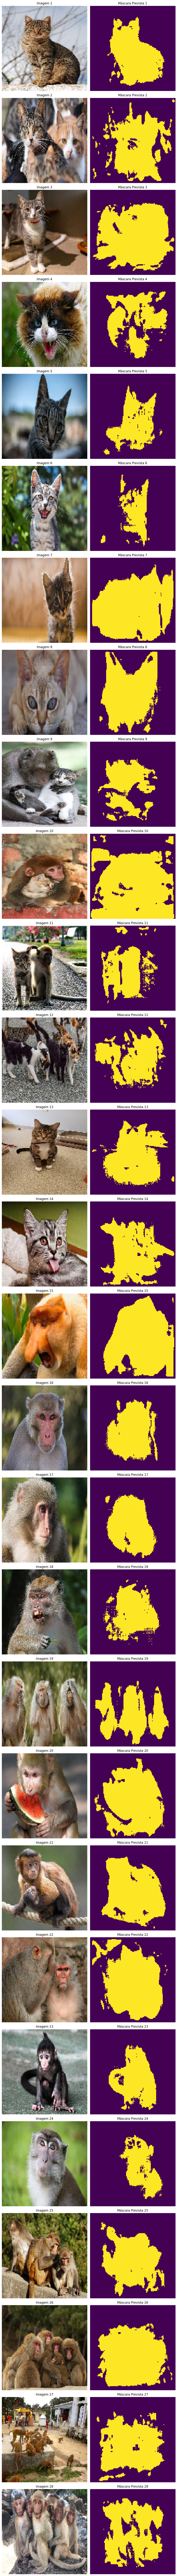

In [4]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
# Caminhos para imagens e máscaras
IMAGE_DIR = 'imgs/'
MASK_DIR = 'masks/'


IMG_SIZE = (128, 128)  # Tamanho de redimensionamento
NUM_CLASSES = 3  # 2 classes (gato e macaco) + 1 fundo
TEST_DIR = 'test/'
# Função para prever e visualizar segmentações de 5 imagens da pasta de teste
def predict_and_plot(model, test_dir, num_images=5):
    """Carrega imagens da pasta de teste, realiza previsões e exibe resultados."""
    test_images = []
    image_filenames = [f for f in os.listdir(test_dir) if f.endswith('.jpg')][:num_images]

    for filename in image_filenames:
        img_path = os.path.join(test_dir, filename)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0  # Normalizar [0, 1]
        test_images.append(img_array)

    test_images = np.array(test_images)
    predictions = model.predict(test_images)

    # Obter a classe com maior probabilidade para cada pixel
    predicted_masks = np.argmax(predictions, axis=-1)

    # Plotar as imagens originais e suas previsões
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for i, (image, predicted_mask) in enumerate(zip(test_images, predicted_masks)):
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Imagem {i + 1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(predicted_mask, cmap='viridis')
        axes[i, 1].set_title(f"Máscara Prevista {i + 1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


model = load_model('unet_model_annoted.h5')
predict_and_plot(model, TEST_DIR, num_images=28)